## 1. Descripción de cada librería

### 🔹 Librerías estándar
- **time** → permite medir tiempos de ejecución y programar pausas controladas.  
- **math** → proporciona funciones matemáticas avanzadas como logaritmos o raíces cuadradas.  
- **json** → se usa para leer y escribir archivos JSON, formato habitual en APIs y configuraciones.

### 🔹 Ciencia de datos
- **numpy (`np`)** → ofrece operaciones rápidas sobre arreglos multidimensionales.  
- **pandas (`pd`)** → permite manipular datos tabulares mediante estructuras `DataFrame`.

### 🔹 Visualización
- **matplotlib.pyplot (`plt`)** → genera gráficos bidimensionales personalizables.  
- **mpl_toolkits.mplot3d (Axes3D)** → habilita gráficos tridimensionales.  
- **seaborn (`sns`)** → simplifica la creación de gráficos estadísticos con una estética moderna.

### 🔹 Machine Learning y Reducción de Dimensionalidad
- **PCA (Principal Component Analysis)** → técnica de reducción de dimensionalidad implementada en `sklearn.decomposition`.

### 🔹 Deep Learning
- **torch** → framework de cómputo con tensores que soporta redes neuronales y GPU.

### 🔹 API y Tokenización
- **openai** → permite conectarse a los modelos GPT o de embeddings de OpenAI.  
- **tiktoken** → ayuda a calcular el número de tokens que utiliza un texto antes de enviarlo a un modelo.

### 🔹 Utilidades
- **tqdm** → muestra barras de progreso útiles en procesos largos o iteraciones extensas.


In [ ]:
# Librerías estándar de Python
import time
import math
import json
import numpy as np
import pandas as pd

# Visualización y gráficos
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para proyecciones 3D
import seaborn as sns

# Machine Learning y Reducción de Dimensionalidad
from sklearn.decomposition import PCA

# PyTorch para tensores y operaciones de atención
import torch
import torch.nn as nn

# OpenAI API (para embeddings y generación de texto)
from openai import OpenAI

# Tokenización
import tiktoken

# Barra de progreso
from tqdm import tqdm

# 2. Configuración del cliente de OpenAI y parámetros del modelo

En este bloque se inicializa el cliente de **OpenAI** y se configuran los modelos utilizados para la generación de texto y embeddings.

### 🔹 Descripción general

- **Cliente OpenAI:** se crea una instancia de conexión con la API mediante una clave de autenticación.
- **Modelos utilizados:**
  - `gpt-4o-mini` → modelo de lenguaje para procesamiento y generación de texto.
  - `text-embedding-ada-002` → modelo especializado en generar *embeddings* vectoriales para análisis semántico y similitud de textos.
- **Prompt principal:** se define un texto de instrucciones (prompt) que guía al modelo para asignar automáticamente un ticket a un desarrollador, calculando las horas estimadas, semanas de duración y fecha de finalización.

El prompt está diseñado para que el modelo **solo devuelva un objeto JSON estructurado**, sin texto adicional, siguiendo reglas específicas de negocio.

## Estructura del Prompt

El prompt se utiliza como guía de entrada para el modelo `gpt-4o-mini`.  
Su propósito es simular un asistente inteligente que asigna tickets de soporte técnico a desarrolladores disponibles.

### Reglas del prompt

1. **Formato de salida:**  
   El modelo debe devolver **únicamente un objeto JSON**, sin explicaciones adicionales.

2. **Campos esperados:**
   - `developer_name`: nombre del desarrollador asignado.
   - `Identity`: número de identificación del desarrollador.
   - `estimated_hours`: número entero de horas estimadas según prioridad y complejidad.
   - `weeks_duration`: duración estimada en semanas (considerando 40 h/semana).
   - `completion_date`: fecha estimada de finalización, calculada desde el 22 de octubre de 2025.

3. **Lógica de estimación:**
   - Tareas **bajas**: entre 8 y 16 horas.  
   - Tareas **medias**: entre 24 y 40 horas.  
   - Tareas **altas**: entre 60 y 80 horas.

4. **Contexto del ticket:**
   - El problema describe un **fallo crítico en un servidor** debido a sobrecalentamiento.
   - La solución propuesta es un **cambio urgente**, lo que implica **alta prioridad y complejidad**.

5. **Base de conocimiento del modelo:**
   Se incluyen perfiles detallados de cuatro desarrolladores, con información sobre:
   - Identidad, educación y experiencia.
   - Habilidades técnicas.
   - Nivel de inglés.
   Esto permite al modelo tomar una decisión informada sobre quién está mejor calificado para resolver el incidente.

### Resultado esperado

El modelo debe analizar el contexto del ticket, comparar las habilidades de los desarrolladores, y generar un JSON estructurado con la asignación más adecuada.


In [ ]:
client = OpenAI(
    api_key=""
)

MODEL_CHAT = "gpt-4o-mini"
MODEL_EMBED = "text-embedding-ada-002"

PROMPT = """
You are an assistant that assigns IT tickets to developers. Return only a JSON object with the following fields:
- developer_name: (string)
- Identity: (string)
- estimated_hours: (integer, only the number of hours)
- weeks_duration: (integer, only the number of weeks)
- completion_date: (date in YYYY-MM-DD format)

Rules:
- Do not add explanations or extra text, only the JSON.
- Hours must match the priority and complexity:
  * Low priority & low complexity ≈ 8–16 hours
  * Medium priority & medium complexity ≈ 24–40 hours
  * High priority & high complexity ≈ 60–80 hours
- Weeks duration must be calculated assuming a 40-hour workweek.
- Completion_date must consider the current date is 2025-10-22.
  Start on the next business day (Monday if weekend) and end on the last business day needed.

TICKET DETAILS
Idea / Issue Description: El servidor se quemó por poca refrigeración
Proposed Solution: Cambio urgente

CURRENT DEVELOPERS
DEVELOPER 1:
⦁ Name: Juan Sebastián Rincon Bernal
⦁ Identity: 110001
⦁ Professional Profile: Infrastructure / Cloud
⦁ Work Experience:
  - Gestión y monitoreo de infraestructura en la nube con AWS y Azure.
  - Implementación de soluciones de virtualización y contenedores.
  - Configuración de redes seguras y despliegue de sistemas escalables.
⦁ Education: Ingeniería de Sistemas - Universidad Ejemplo (2015 - 2020)
⦁ Technical Skills:
  - Administración de servidores
  - AWS
  - Azure
  - Google Cloud
  - Docker
  - Kubernetes
  - Redes y seguridad
⦁ Languages:
  - Español - Nativo
  - Inglés - Intermedio

DEVELOPER 2:
⦁ Name: Santiago Ramirez Prada
⦁ Identity: 109729
⦁ Professional Profile: Automation / RPA
⦁ Work Experience:
  - Diseño e implementación de robots RPA para automatizar procesos repetitivos.
  - Reducción de tiempos de gestión administrativa mediante flujos automáticos.
  - Integración de bots con sistemas ERP y CRM.
⦁ Education: Ingeniería de Sistemas - Universidad Ejemplo (2015 - 2020)
⦁ Technical Skills:
  - Automatización de procesos
  - UiPath
  - Automation Anywhere
  - Python
  - Power Automate
  - Integración de sistemas
⦁ Languages:
  - Español - Nativo
  - Inglés - Intermedio

DEVELOPER 3:
⦁ Name: David Germán Ramirez Rincón
⦁ Identity: 100814
⦁ Professional Profile: BI / Analytics
⦁ Work Experience:
  - Desarrollo de tableros de control interactivos con Power BI.
  - Modelado de datos y procesos ETL para análisis de grandes volúmenes de información.
  - Implementación de soluciones de analítica predictiva.
⦁ Education: Ingeniería de Sistemas - Universidad Ejemplo (2015 - 2020)
⦁ Technical Skills:
  - Business Intelligence
  - Power BI
  - Tableau
  - SQL
  - ETL
  - Python para análisis de datos
  - Estadística
⦁ Languages:
  - Español - Nativo
  - Inglés - Intermedio

DEVELOPER 4
⦁ Name: Johana Ibáñez Quiroga
⦁ Identity: 50650
⦁ Professional Profile: Software Development (Web, App, Backend, API)
⦁ Work Experience:
  - Desarrolladora Full Stack en proyectos de aplicaciones web y móviles.
  - Implementación de APIs REST para integración de sistemas internos.
  - Optimización de procesos en aplicaciones backend con Node.js y Django.
⦁ Education: Ingeniería de Sistemas - Universidad Ejemplo (2015 - 2020)
⦁ Technical Skills:
  - Desarrollo Web
  - Desarrollo Backend
  - APIs REST
  - Java
  - Python
  - JavaScript
  - Bases de Datos SQL/NoSQL
⦁ Languages:
  - Español - Nativo
  - Inglés - Intermedio
"""

# PASOS DEL MODELO TRANSFORMER
-------------------

# 1. Tokenización del Prompt

Antes de enviar el *prompt* al modelo de OpenAI, es útil analizar cuántos **tokens** ocupa el texto.  
Un *token* representa una unidad básica de texto que el modelo entiende: puede ser una palabra, parte de una palabra o incluso un símbolo.

Esta etapa utiliza la librería **`tiktoken`**, que permite tokenizar texto exactamente igual que los modelos de OpenAI.

### Objetivos de esta sección

1. Obtener el **codificador** compatible con el modelo `gpt-4o-mini`.  
2. Codificar el *prompt* en una secuencia de **IDs numéricos de tokens**.  
3. Decodificar cada ID para ver los **fragmentos de texto reales** asociados.  
4. Visualizar el resultado para entender cómo el modelo interpreta internamente el texto.

Esto resulta útil para:
- Validar que el *prompt* no exceda el límite de tokens permitido.  
- Analizar cómo se fragmenta el texto (especialmente en idiomas distintos del inglés).  
- Comprender la relación entre tamaño del texto y costo de procesamiento.


In [ ]:
# 1. Tokenización
enc = tiktoken.encoding_for_model(MODEL_CHAT)
token_ids = enc.encode(PROMPT)
tokens = [enc.decode([tid]) for tid in token_ids]

print("Tokens:", tokens)
print("Token IDs:", token_ids)

Tokens: ['\n', 'You', ' are', ' an', ' assistant', ' that', ' assigns', ' IT', ' tickets', ' to', ' developers', '.', ' Return', ' only', ' a', ' JSON', ' object', ' with', ' the', ' following', ' fields', ':\n', '-', ' developer', '_name', ':', ' (', 'string', ')\n', '-', ' Identity', ':', ' (', 'string', ')\n', '-', ' estimated', '_hours', ':', ' (', 'integer', ',', ' only', ' the', ' number', ' of', ' hours', ')\n', '-', ' weeks', '_duration', ':', ' (', 'integer', ',', ' only', ' the', ' number', ' of', ' weeks', ')\n', '-', ' completion', '_date', ':', ' (', 'date', ' in', ' YYYY', '-MM', '-DD', ' format', ')\n\n', 'Rules', ':\n', '-', ' Do', ' not', ' add', ' explanations', ' or', ' extra', ' text', ',', ' only', ' the', ' JSON', '.\n', '-', ' Hours', ' must', ' match', ' the', ' priority', ' and', ' complexity', ':\n', ' ', ' *', ' Low', ' priority', ' &', ' low', ' complexity', ' �', '�', ' ', '8', '–', '16', ' hours', '\n', ' ', ' *', ' Medium', ' priority', ' &', ' medium', '

### **2. Generación de Embeddings por Token**

En esta sección se realiza la **transformación de cada token del texto en un vector numérico** (embedding), utilizando el modelo `text-embedding-ada-002` de OpenAI.  

Los **embeddings** son representaciones matemáticas de palabras o fragmentos de texto en un espacio de alta dimensión (1536 dimensiones en este caso).  
Cada vector captura el **significado semántico** del token, permitiendo analizar relaciones entre palabras, calcular similitudes o aplicar técnicas de reducción de dimensionalidad y visualización.

---

#### **Flujo general del proceso**

1. **Selección de una muestra de tokens**
   - Para optimizar tiempo y consumo de API, se seleccionan los primeros 30 tokens del texto procesado.
   - Esto permite realizar pruebas iniciales sin procesar el texto completo.

2. **Obtención de embeddings por token**
   - Se realiza una llamada a la API de OpenAI para cada token, solicitando su vector de representación.
   - Cada respuesta contiene un vector de 1536 valores (float), que representan la posición del token en el espacio semántico del modelo.

3. **Construcción de una matriz de embeddings**
   - Todos los vectores se almacenan en una matriz `NumPy` con forma `(num_tokens, 1536)`.
   - Esta matriz es ideal para análisis posteriores con técnicas de Machine Learning o Visualización.

4. **Creación de una tabla resumen**
   - Se muestra un `DataFrame` con los primeros 5 valores de cada embedding para inspección visual.
   - Esto permite verificar que los embeddings se generaron correctamente y observar variaciones entre tokens.

---

#### **Conceptos clave**

| Concepto | Descripción |
|:----------|:-------------|
| **Token** | Unidad mínima de texto reconocida por el modelo (palabra, símbolo o subpalabra). |
| **Embedding** | Vector numérico de alta dimensión que representa el significado del token. |
| **Dimensión (1536)** | Número de valores que describen cada token dentro del espacio semántico. |
| **Matriz de Embeddings** | Conjunto organizado de todos los vectores generados (tokens × dimensiones). |

---

#### **Objetivo práctico**

El propósito de este paso es **obtener una representación cuantitativa del texto** para realizar análisis posteriores, como:
- Comparación de similitud entre tokens.
- Agrupación semántica.
- Visualización 2D/3D.
---

A continuación se implementa el proceso descrito en el siguiente bloque de código:




In [ ]:
# 2. Obtener embeddings por token
tokens_sample = tokens[:30]
rows = []

print(f"\nGenerando embeddings para {len(tokens_sample)} tokens...\n")

for t in tqdm(tokens_sample, desc="Procesando tokens", ncols=90, dynamic_ncols=True):
    try:
        emb_resp = client.embeddings.create(input=t, model=MODEL_EMBED)
        emb = emb_resp.data[0].embedding
        rows.append({"token": t, "embedding": emb})
        time.sleep(0.1)
    except Exception as e:
        print(f"Error al procesar token '{t}': {e}")
        continue

print(f"\nEmbeddings generados correctamente para {len(rows)} tokens.\n")

# 2.2 Convertimos los embeddings en una matriz numérica (num_tokens x 1536)
emb_matrix = np.array([r["embedding"] for r in rows])
print(f"Shape de emb_matrix: {emb_matrix.shape} (tokens x dimensiones)")

# 2.3 Tabla resumida (primeras 5 dimensiones)
preview = []
for r in rows:
    dims = {f"dim_{i}": r["embedding"][i] for i in range(5)}
    preview.append({"token": r["token"], **dims})
df = pd.DataFrame(preview)

print("\nTabla de Embeddings por Token (primeras 5 dimensiones):")
print(df)


Generando embeddings para 30 tokens...



Procesando tokens: 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


Embeddings generados correctamente para 30 tokens.

Shape de emb_matrix: (30, 1536) (tokens x dimensiones)

Tabla de Embeddings por Token (primeras 5 dimensiones):
          token     dim_0     dim_1     dim_2     dim_3     dim_4
0            \n  0.002512 -0.018246  0.016877 -0.012145 -0.012100
1           You -0.011961 -0.003479  0.023802 -0.014622 -0.016218
2           are -0.003655 -0.011217  0.009462 -0.018520 -0.015382
3            an -0.021602  0.007061  0.001575 -0.000703 -0.014986
4     assistant -0.035236  0.009193  0.004881 -0.016555 -0.019436
5          that -0.005069 -0.011141  0.009351 -0.015357 -0.014395
6       assigns -0.036000 -0.014629 -0.007261 -0.002365 -0.003246
7            IT -0.014485  0.000729 -0.005880 -0.009317 -0.003447
8       tickets -0.012051 -0.024102 -0.008824 -0.029490 -0.013418
9            to -0.004547 -0.008616  0.010041 -0.012119 -0.014432
10   developers  0.008467 -0.017203 -0.003863 -0.022699 -0.008999
11            . -0.008797 -0.017017  0.0049

### **3. Llamada al modelo de Chat (GPT-4-Mini)**

En esta sección se realiza una interacción directa con el modelo de lenguaje GPT-4-Mini para generar una respuesta inteligente basada en el contexto definido previamente.  

El objetivo es simular el comportamiento de un *sistente especializado en asignación de tickets de soporte IT, capaz de analizar descripciones de incidencias y asignarlas al desarrollador más adecuado, generando un objeto JSON estructurado con la información requerida.

---

#### **Funcionamiento general del bloque**

1. **Definición del modelo de chat**
   - Se utiliza `MODEL_CHAT = "gpt-4o-mini"`, un modelo optimizado de OpenAI diseñado para tareas de razonamiento y generación de texto con alta eficiencia.
   - Este modelo interpreta instrucciones complejas y produce salidas estructuradas según lo indicado en el *prompt*.

2. **Estructura del mensaje**
   - La API recibe una lista de mensajes en formato conversación, donde cada uno tiene un `role` y un `content`:
     - `system`: Define las reglas y el comportamiento general del asistente (en este caso, su rol como asignador de tickets IT).
     - `user`: Contiene el *prompt* completo con la descripción del problema, los desarrolladores disponibles y las reglas de salida.

   Esto permite simular un contexto conversacional, como si el modelo estuviera respondiendo dentro de un chat con un usuario.

3. **Parámetros de generación**
   - `temperature=0.0`: Hace que las respuestas sean **determinísticas**, es decir, el modelo siempre devuelve el mismo resultado ante la misma entrada.
   - `max_completion_tokens=100`: Limita el tamaño máximo de la respuesta a 100 tokens, suficiente para un objeto JSON compacto.

4. **Obtención de la respuesta**
   - El resultado devuelto por el modelo se almacena en `resp`, un objeto estructurado que contiene una lista de posibles respuestas (`choices`).
   - Se selecciona la primera (`choices[0]`) y se imprime únicamente el contenido generado (`choice.message.content`).

---

#### **Propósito de esta sección**

Este bloque tiene como finalidad **probar la lógica del prompt** y verificar que el modelo:
- Analiza correctamente el contexto del ticket.
- Identifica el desarrollador con el perfil más adecuado.
- Devuelve una respuesta estructurada en formato **JSON válido**, con los campos:
  - `developer_name`
  - `Identity`
  - `estimated_hours`
  - `weeks_duration`
  - `completion_date`

---

#### **Resultado esperado**

La salida esperada del modelo debe tener el siguiente formato (sin texto adicional):

```json
{
  "developer_name": "Juan Sebastián Rincon Bernal",
  "Identity": "110001",
  "estimated_hours": 80,
  "weeks_duration": 2,
  "completion_date": "2025-11-05"
}


In [ ]:
# 3. Llamada al modelo de chat (GPT-4-Mini)
resp = client.chat.completions.create(
    model=MODEL_CHAT,
    messages=[
        {"role": "system", "content": "You are an assistant that assigns IT tickets to developers."},
        {"role": "user", "content": PROMPT},
    ],
    temperature=0.0,
    max_completion_tokens=100,
)

choice = resp.choices[0]
print("\nRespuesta JSON:")
print(choice.message.content)


Respuesta JSON:
```json
{
  "developer_name": "Juan Sebastián Rincon Bernal",
  "Identity": "110001",
  "estimated_hours": 60,
  "weeks_duration": 2,
  "completion_date": "2025-11-05"
}
```


### 4. Visualización 3D de Embeddings  

En esta sección se busca **representar gráficamente los embeddings generados** por el modelo para cada token, con el fin de observar su relación semántica dentro de un espacio tridimensional.  

Los embeddings son vectores numéricos de alta dimensionalidad (generalmente de 1536 dimensiones en el caso del modelo *text-embedding-ada-002*).  
Para poder visualizarlos de manera comprensible, se utiliza una técnica de reducción de dimensionalidad conocida como **PCA (Principal Component Analysis)**, que permite proyectar estos vectores en un espacio de 3 dimensiones, conservando la mayor cantidad posible de información.  

---

#### Lógica del código  

1. **Conversión a matriz numérica:**  
   Se extraen todos los vectores de embeddings almacenados en la lista `rows` y se convierten en una matriz NumPy llamada `emb_matrix`.  
   Cada fila de esta matriz representa el embedding correspondiente a un token o palabra.  

2. **Verificación de datos:**  
   Antes de proceder, se comprueba que existan suficientes muestras (al menos tres) para realizar una proyección 3D válida. Si no se cumple esta condición, el proceso se detiene.  

3. **Reducción de dimensionalidad (PCA):**  
   - Se calculan las dimensiones originales de la matriz (`n_samples`, `n_features`).  
   - Se determina el número de componentes principales que se usarán para la proyección (`n_components`), asegurando que no sea mayor a 3.  
   - Se aplica PCA para reducir los vectores a tres dimensiones (`coords3d`).  

4. **Ajuste dimensional:**  
   En caso de que el resultado del PCA tenga solo dos componentes, se agrega una tercera columna de ceros para permitir su visualización en 3D sin errores.  

5. **Visualización con Matplotlib:**  
   - Se genera una figura tridimensional con los puntos resultantes de la reducción.  
   - Cada punto representa un token y se colorea de forma distinta para facilitar su identificación.  
   - Encima de cada punto se muestra una etiqueta con el texto del token (limitado a 10 caracteres para evitar superposición).  
   - Finalmente, se muestra el gráfico con un título descriptivo que indica el modelo utilizado.  

---

#### Variables clave  

| Variable | Descripción |
|-----------|--------------|
| `rows` | Lista de diccionarios que contiene los embeddings generados para cada token. |
| `emb_matrix` | Matriz NumPy que agrupa todos los vectores de embeddings. |
| `n_samples`, `n_features` | Número de tokens procesados y dimensiones de cada vector. |
| `n_components` | Número de dimensiones objetivo para la reducción PCA (máximo 3). |
| `coords3d` | Matriz resultante con las coordenadas 3D de los embeddings reducidos. |
| `tokens` | Lista de palabras o fragmentos de texto correspondientes a cada embedding. |

---

#### Resultado esperado  

Se obtiene un **gráfico tridimensional** donde cada punto representa un token en el espacio de embeddings.  
Tokens con significados o contextos similares tenderán a ubicarse más cerca entre sí, permitiendo una interpretación visual de la relación semántica entre ellos.  


Dimensiones de emb_matrix: (30, 1536)


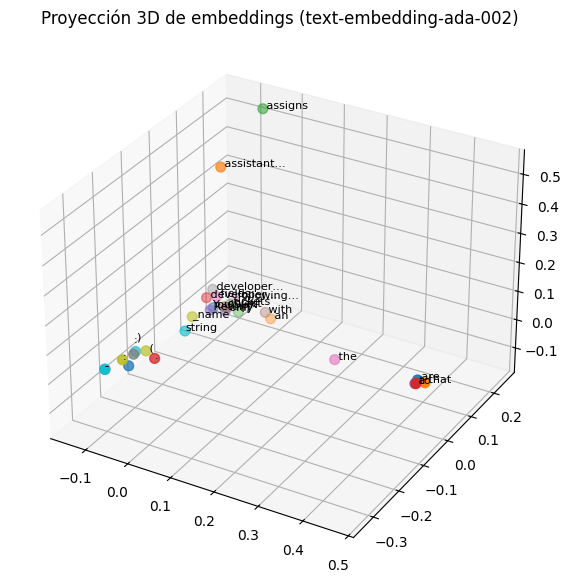

In [ ]:
# 4. Visualización 3D de embeddings
emb_matrix = np.array([r["embedding"] for r in rows])
print("Dimensiones de emb_matrix:", emb_matrix.shape)

if emb_matrix.size == 0 or emb_matrix.shape[0] < 3:
    print("No hay suficientes datos para generar una proyección PCA 3D.")
else:
    n_samples, n_features = emb_matrix.shape
    n_components = min(3, n_samples, n_features)
    pca = PCA(n_components=n_components)
    coords3d = pca.fit_transform(emb_matrix)

    if coords3d.shape[1] == 2:
        coords3d = np.hstack([coords3d, np.zeros((coords3d.shape[0], 1))])

    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(coords3d[:, 0], coords3d[:, 1], coords3d[:, 2], c=range(len(coords3d)), cmap="tab10", s=50)

    for i, t in enumerate(tokens[:len(coords3d)]):
        token_label = t if len(t) < 10 else t[:10] + "…"
        ax.text(coords3d[i, 0], coords3d[i, 1], coords3d[i, 2], token_label, fontsize=8)

    ax.set_title("Proyección 3D de embeddings (text-embedding-ada-002)")
    plt.show()


### 5. Implementación del Mecanismo de Self-Attention

En esta sección se implementa de forma práctica el mecanismo de Self-Attention, uno de los pilares fundamentales en los modelos tipo Transformer (como GPT o BERT).  
El objetivo es mostrar cómo cada token de una secuencia “atiende” a los demás para construir una representación contextual más precisa, considerando el significado de las palabras vecinas.

El proceso se divide en tres partes:
1. **Self-Attention con una sola cabeza.**
2. **Simulación de Multi-Head Self-Attention.**
3. **Visualización comparativa antes y después del Self-Attention.**

---

#### 5.1. Self-Attention con una cabeza

1. **Selección de subconjunto de embeddings**
   - Se toman los primeros 30 embeddings (`limit = 30`) para simplificar los cálculos y reducir carga computacional.
   - La matriz `X` contendrá los vectores de estos tokens, con forma `(n_tokens, d_model)`.

2. **Inicialización de pesos de proyección**
   - Se generan tres matrices aleatorias de proyección:  
     - `W_Q` (Queries),  
     - `W_K` (Keys),  
     - `W_V` (Values).  
   - Estas matrices transforman los embeddings originales en representaciones que capturan distintas relaciones contextuales.

3. **Cálculo de las matrices Q, K y V**
   - Se obtiene:
     \[
     Q = XW_Q,\quad K = XW_K,\quad V = XW_V
     \]
   - Estas matrices definen cómo cada token “pregunta” (Q), “se describe” (K) y “se representa” (V) dentro de la secuencia.

4. **Cálculo de los *scores* de atención**
   - Los puntajes de atención se calculan mediante el producto punto entre Q y K, escalado por la raíz cuadrada de la dimensión de K (`d_k`):
     \[
     \text{scores} = \frac{QK^T}{\sqrt{d_k}}
     \]
   - Este valor mide cuánta atención debe prestar cada token a los demás.

5. **Aplicación de Softmax**
   - Se aplica una función *softmax* fila por fila para convertir los puntajes en probabilidades normalizadas (`attention_weights`), que suman 1 en cada fila.

6. **Cálculo del output**
   - El resultado final de la atención se obtiene multiplicando los pesos por la matriz de valores:
     \[
     \text{output} = \text{attention\_weights} \times V
     \]
   - Esto produce una nueva representación contextual para cada token.

7. **Visualización de la matriz de atención**
   - Se genera un mapa de calor (*heatmap*) con **Seaborn**, donde:
     - Las filas representan los *tokens que atienden*.
     - Las columnas, los *tokens atendidos*.
   - Colores más intensos indican mayor atención.

---

#### Variables clave

| Variable | Descripción |
|-----------|--------------|
| `X` | Matriz de embeddings iniciales (tokens × dimensiones). |
| `W_Q`, `W_K`, `W_V` | Pesos de proyección para Queries, Keys y Values. |
| `Q`, `K`, `V` | Representaciones intermedias de los tokens. |
| `scores` | Matriz de puntajes de atención antes de normalizar. |
| `attention_weights` | Matriz de probabilidades de atención entre tokens. |
| `output` | Representación final del Self-Attention. |

---

#### 5.2. Multi-Head Self-Attention (4 cabezas)

1. Se simula el mecanismo **Multi-Head**, que divide el espacio de atención en varias “cabezas” independientes (en este caso, 4).
2. Cada cabeza aprende relaciones diferentes entre tokens.
3. Los resultados de las cuatro cabezas se concatenan y se combinan mediante una matriz `W_O`.
4. Finalmente, se visualizan los mapas de atención individuales de cada cabeza, permitiendo observar cómo cada una se enfoca en distintos patrones de dependencia contextual.

---

#### 5.3. Comparación visual antes y después del Self-Attention

- Se utiliza **PCA (Análisis de Componentes Principales)** para proyectar los embeddings antes y después del Self-Attention a 3 dimensiones.
- Se generan dos gráficos 3D:
  - **Antes del Self-Attention:** muestra los embeddings originales del modelo de OpenAI.
  - **Después del Multi-Head Self-Attention:** muestra cómo las posiciones de los tokens cambian tras el proceso de atención, evidenciando la captura de dependencias contextuales.

---

#### Resultado esperado

- Un mapa de atención que muestra cómo cada token “mira” a otros dentro de la secuencia.
- Cuatro mapas de atención por cabeza, donde cada uno resalta diferentes relaciones semánticas.
- Una comparación visual que evidencia la transformación de los embeddings después de aplicar el mecanismo de atención.

Este paso permite comprender de forma visual e intuitiva cómo los modelos tipo Transformer aprenden contexto y significado, ajustando dinámicamente la atención entre palabras.


Procesando Self-Attention con 30 tokens de 1536 dimensiones
Shape del output (Self-Attention resultante): (30, 64)
Shape de la matriz de atención: (30, 30)

Matriz de atención (primeros 10 tokens):
               \n    You    are     an   assistant   that   assigns     IT  \
\n          0.021  0.012  0.036  0.039       0.179  0.041     0.046  0.015   
You         0.029  0.021  0.032  0.050       0.135  0.034     0.052  0.016   
 are        0.030  0.020  0.019  0.037       0.140  0.020     0.050  0.018   
 an         0.022  0.016  0.025  0.061       0.196  0.027     0.043  0.015   
 assistant  0.040  0.038  0.028  0.048       0.085  0.027     0.041  0.022   
 that       0.031  0.020  0.018  0.036       0.142  0.019     0.048  0.019   
 assigns    0.043  0.022  0.028  0.051       0.160  0.029     0.010  0.014   
 IT         0.027  0.024  0.026  0.053       0.108  0.028     0.038  0.018   
 tickets    0.029  0.015  0.026  0.040       0.173  0.029     0.058  0.020   
 to         0.029  0.0

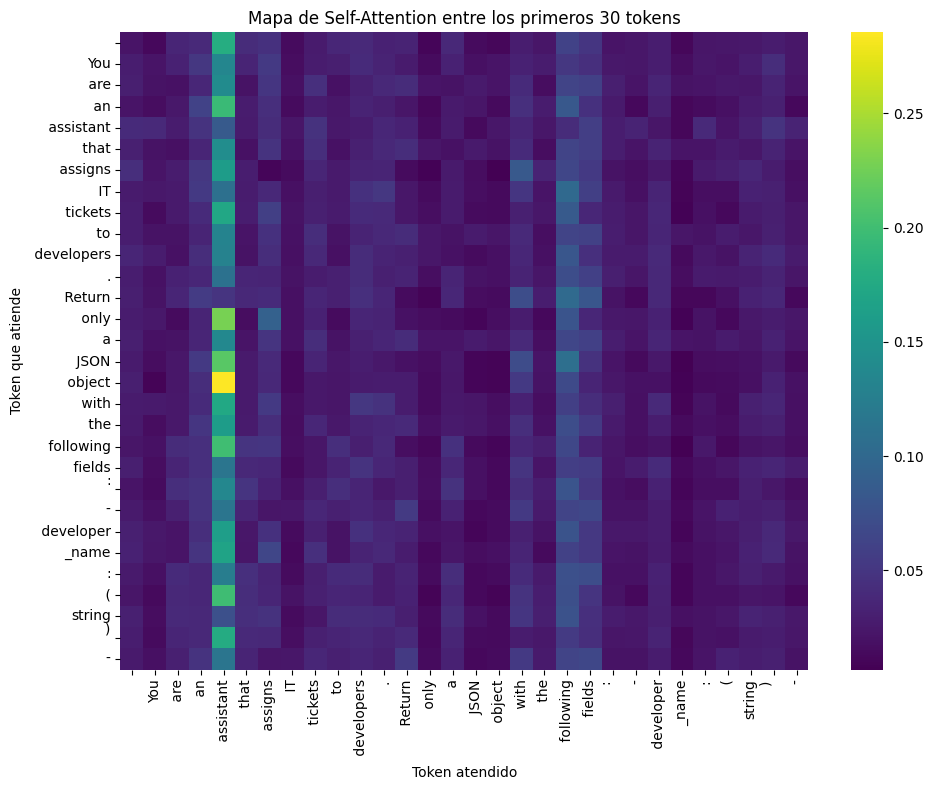

Shape del output final tras Multi-Head Attention: torch.Size([30, 1536])
 (Tokens: 30, Dimensiones: 1536)


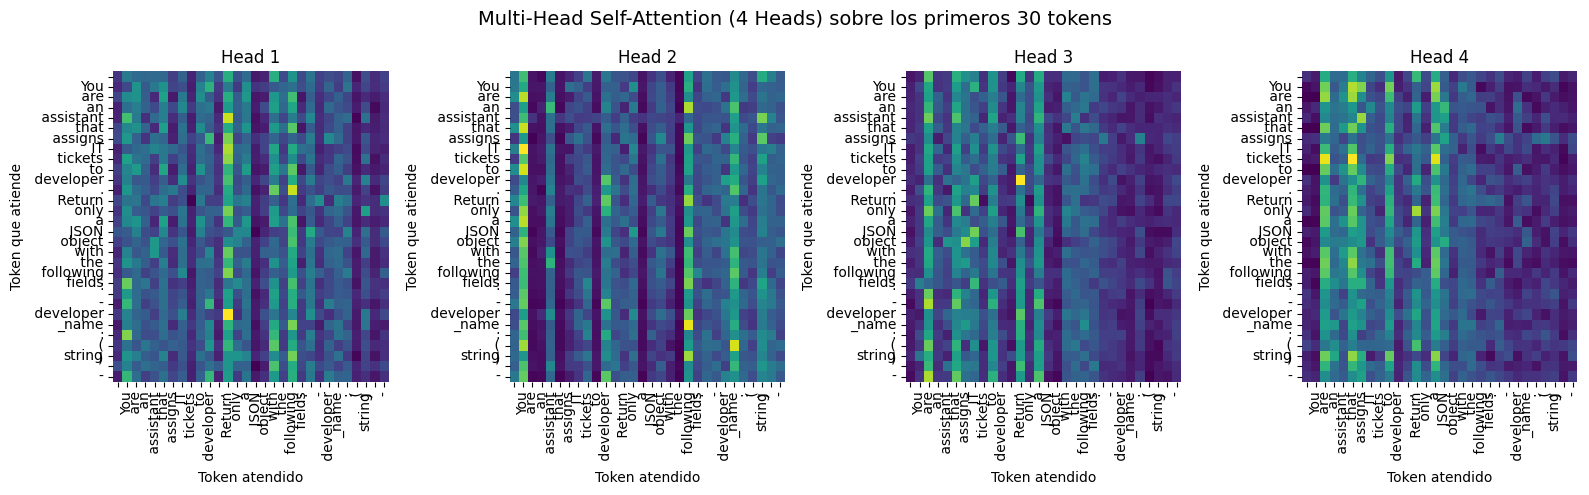


🧩 Output final tras Multi-Head Attention (primeras 5 dimensiones por token):
      token      dim_0      dim_1     dim_2     dim_3      dim_4
         \n -28.898634 -38.691639 43.666668 16.038895 -16.224182
        You -30.266657 -38.788475 44.169540 17.740557 -15.694016
        are -30.384783 -39.556671 44.290813 17.049543 -16.562307
         an -30.218798 -40.071480 43.422569 15.937864 -16.515940
  assistant -28.638271 -36.113400 42.830311 15.443925 -19.333363
       that -30.409138 -39.579460 44.320374 16.511642 -16.907433
    assigns -30.287735 -39.001579 46.109516 14.974688 -17.650097
         IT -30.546392 -39.306393 43.956619 17.815914 -15.614384
    tickets -30.255390 -38.971535 44.466232 18.823727 -15.118696
         to -30.498026 -39.377911 44.146996 16.522055 -16.862991
 developers -29.440678 -41.374065 44.961525 15.533329 -17.079849
          . -29.857418 -39.000401 42.624054 16.919111 -16.080173
     Return -30.112015 -40.549744 44.453484 15.412427 -15.482908
       only 

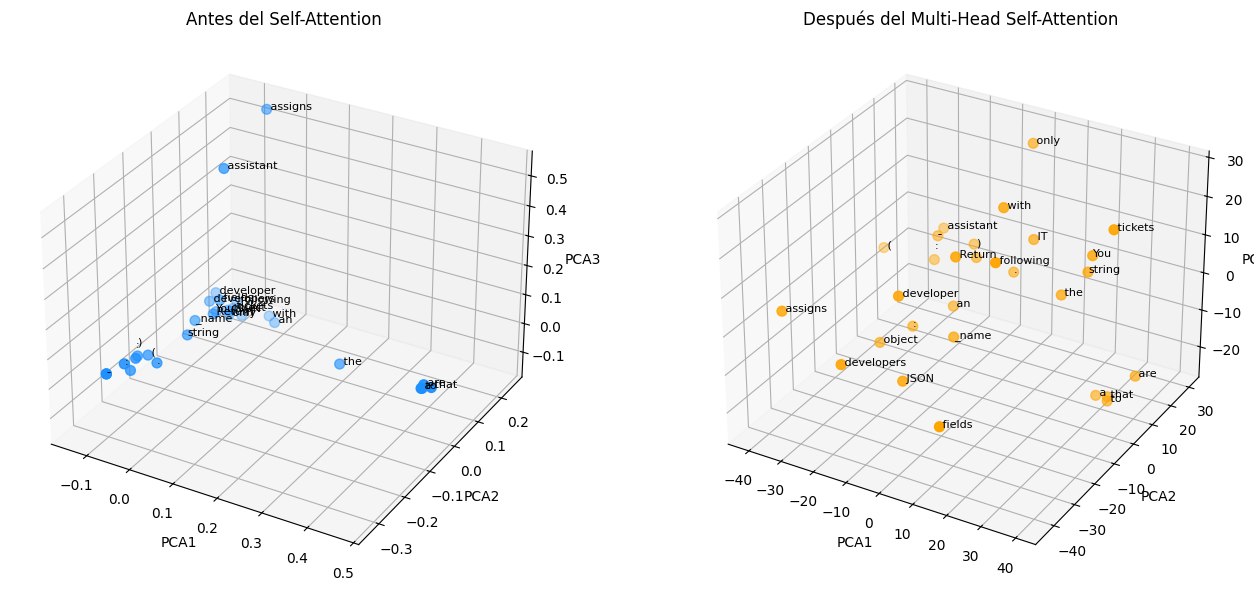

In [ ]:
# 5. Self Attention con una cabeza
limit = 30
X = emb_matrix[:limit]
subset_tokens = tokens[:limit]
n_tokens, d_model = X.shape
d_k = 64

print(f"Procesando Self-Attention con {n_tokens} tokens de {d_model} dimensiones")

np.random.seed(42)
W_Q = np.random.randn(d_model, d_k)
W_K = np.random.randn(d_model, d_k)
W_V = np.random.randn(d_model, d_k)

Q = X @ W_Q
K = X @ W_K
V = X @ W_V

scores = (Q @ K.T) / np.sqrt(d_k)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

attention_weights = softmax(scores)
output = attention_weights @ V

print(f"Shape del output (Self-Attention resultante): {output.shape}")
print(f"Shape de la matriz de atención: {attention_weights.shape}")

att_df = pd.DataFrame(attention_weights, columns=subset_tokens, index=subset_tokens)
print("\nMatriz de atención (primeros 10 tokens):")
print(att_df.iloc[:10, :10].round(3))

plt.figure(figsize=(10, 8))
sns.heatmap(att_df, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title("Mapa de Self-Attention entre los primeros 30 tokens")
plt.xlabel("Token atendido")
plt.ylabel("Token que atiende")
plt.tight_layout()
plt.show()

# 5.1 Multi-Head Self-Attention Simulation (4 heads)
X = torch.tensor(emb_matrix[:30], dtype=torch.float32)
num_tokens, d_model = X.shape
num_heads = 4
d_k = d_model // num_heads

W_Q = torch.randn(num_heads, d_model, d_k)
W_K = torch.randn(num_heads, d_model, d_k)
W_V = torch.randn(num_heads, d_model, d_k)
W_O = torch.randn(num_heads * d_k, d_model)

attention_maps = []
head_outputs = []

for h in range(num_heads):
    Q = X @ W_Q[h]
    K = X @ W_K[h]
    V = X @ W_V[h]

    scores = (Q @ K.T) / np.sqrt(d_k)
    attn = torch.softmax(scores, dim=-1)
    attention_maps.append(attn.detach().numpy())

    head_output = attn @ V
    head_outputs.append(head_output)

concat_output = torch.cat(head_outputs, dim=-1)
final_output = concat_output @ W_O

print(f"Shape del output final tras Multi-Head Attention: {final_output.shape}")
print(f" (Tokens: {num_tokens}, Dimensiones: {d_model})")

fig, axes = plt.subplots(1, num_heads, figsize=(16, 5))
fig.suptitle("Multi-Head Self-Attention (4 Heads) sobre los primeros 30 tokens", fontsize=14)

for i, ax in enumerate(axes):
    sns.heatmap(
        attention_maps[i],
        ax=ax,
        cmap="viridis",
        cbar=False,
        xticklabels=[t[:10] for t in tokens[:30]],
        yticklabels=[t[:10] for t in tokens[:30]],
    )
    ax.set_title(f"Head {i+1}")
    ax.set_xlabel("Token atendido")
    ax.set_ylabel("Token que atiende")

plt.tight_layout()
plt.show()

# 5.2 Tabla resumen del output final
final_output_np = final_output.detach().numpy()
df_output = pd.DataFrame(
    final_output_np[:30, :5],
    columns=[f"dim_{j}" for j in range(5)]
)
df_output.insert(0, "token", tokens[:30])

print("\n🧩 Output final tras Multi-Head Attention (primeras 5 dimensiones por token):")
print(df_output.to_string(index=False))

# 5.3. Comparacion visual entre Embeddings antes y después del Self-Attention
num_tokens_vis = min(30, len(tokens))
tokens_vis = tokens[:num_tokens_vis]

pca_before = PCA(n_components=3)
coords_before = pca_before.fit_transform(emb_matrix[:num_tokens_vis])

pca_after = PCA(n_components=3)
coords_after = pca_after.fit_transform(final_output_np[:num_tokens_vis])

fig = plt.figure(figsize=(14, 6))

# 5.4. Antes del Self-Attention
ax1 = fig.add_subplot(121, projection="3d")
ax1.scatter(coords_before[:, 0], coords_before[:, 1], coords_before[:, 2], c="dodgerblue", s=50)
for i, t in enumerate(tokens_vis):
    ax1.text(coords_before[i, 0], coords_before[i, 1], coords_before[i, 2], t, fontsize=8)
ax1.set_title("Antes del Self-Attention")
ax1.set_xlabel("PCA1")
ax1.set_ylabel("PCA2")
ax1.set_zlabel("PCA3")

# 5.5. Después del Self-Attention
ax2 = fig.add_subplot(122, projection="3d")
ax2.scatter(coords_after[:, 0], coords_after[:, 1], coords_after[:, 2], c="orange", s=50)
for i, t in enumerate(tokens_vis):
    ax2.text(coords_after[i, 0], coords_after[i, 1], coords_after[i, 2], t, fontsize=8)
ax2.set_title("Después del Multi-Head Self-Attention")
ax2.set_xlabel("PCA1")
ax2.set_ylabel("PCA2")
ax2.set_zlabel("PCA3")

plt.tight_layout()
plt.show()

### 6. Implementación del Feed-Forward Network (FNN)

En esta sección se implementa el Feed-Forward Network (FNN), una parte fundamental del bloque Transformer que actúa después del mecanismo de atención.  
Su propósito es refinar las representaciones generadas por el Self-Attention, aplicando transformaciones no lineales que permiten al modelo aprender relaciones más complejas y abstractas entre las características de cada token.

El proceso se desarrolla en cinco pasos principales:

1. **Preparación de datos y parámetros del modelo.**  
2. **Aplicación de la primera normalización de capa (LayerNorm).**  
3. **Construcción del bloque Feed-Forward Network.**  
4. **Conexión residual y normalización final.**  
5. **Visualización de activaciones de un token.**

---

#### 6.1. Preparación de datos y parámetros

- Se toman los primeros 30 embeddings de los tokens como entrada (`x`), transformándolos en tensores de PyTorch.
- Se reutiliza la salida del bloque de atención (`attn_output`), que contiene la información contextual de cada token.
- Se definen los parámetros principales:
  - `d_model`: tamaño del vector de embedding de cada token (1536).
  - `d_ff`: tamaño de la capa oculta del FNN (512), donde se realiza la expansión intermedia de características.

Este paso configura el entorno para procesar los tokens individualmente dentro del bloque Feed-Forward.

---

#### 6.2. Aplicación de Layer Normalization (normalización de capa)

Antes de aplicar la red neuronal, se realiza una **normalización de capa** (`LayerNorm`) sobre la suma residual entre el embedding original (`x`) y la salida de atención (`attn_output`).  
Esto estabiliza las activaciones y evita que las diferencias de escala entre tokens afecten el aprendizaje.

\[
x = \text{LayerNorm}(x + \text{attn\_output})
\]

De esta forma, los valores de cada token quedan centrados y normalizados, listos para pasar por la red feed-forward.

---

#### 6.3. Construcción del bloque Feed-Forward Network (FNN)

El FNN se compone de tres capas principales organizadas secuencialmente:

1. `nn.Linear(d_model, d_ff)`: amplía la dimensión de los vectores de 1536 a 512.
2. `nn.ReLU()`: introduce una función de activación no lineal, permitiendo que el modelo capture relaciones complejas.
3. `nn.Linear(d_ff, d_model)`: reduce la dimensión nuevamente a 1536 para mantener compatibilidad con el flujo residual.

Este bloque transforma cada token **de manera independiente**, sin intercambiar información entre ellos, potenciando su capacidad de representación.

---

#### 6.4. Conexión residual y segunda normalización

Luego de aplicar el FNN, se suma nuevamente la salida con la entrada original (`x`) mediante una **conexión residual**, seguida de otra normalización de capa (`layernorm2`):

\[
\text{output} = \text{LayerNorm}(x + \text{FFN}(x))
\]

Esto permite que el modelo preserve información esencial del embedding original, evitando la pérdida de gradiente y mejorando la estabilidad durante el entrenamiento.

El resultado final, almacenado en `output`, mantiene la misma forma `(30, 1536)` que la entrada, confirmando que la estructura del modelo se conserva.

---

#### 6.5. Visualización de activaciones

Para comprender mejor el comportamiento del FFN, se selecciona un token específico (`token_index = 1`) y se grafican las primeras 100 dimensiones de su vector resultante.  
El gráfico muestra las activaciones del embedding tras pasar por la red Feed-Forward, revelando cómo se ajustan los valores de cada componente interno del token.

Esto proporciona una visión práctica de cómo el modelo transforma la representación semántica interna de cada palabra o símbolo.

---

#### Variables clave

| Variable | Descripción |
|-----------|--------------|
| `x` | Embeddings originales de los tokens seleccionados. |
| `attn_output` | Resultado del bloque de Multi-Head Self-Attention. |
| `d_model` | Dimensión de los embeddings por token (1536). |
| `d_ff` | Dimensión intermedia del Feed-Forward Network (512). |
| `ffn` | Red neuronal secuencial con capas lineales y activación ReLU. |
| `layernorm1`, `layernorm2` | Normalizaciones aplicadas antes y después del FNN. |
| `output` | Representación final del bloque Feed-Forward. |

---

#### Resultado esperado

- Un tensor de salida con la misma forma `(30, 1536)` que el original, lo que garantiza la coherencia estructural.
- Activaciones suavizadas y refinadas para cada token después del bloque Feed-Forward.
- Un gráfico que ilustra las variaciones en las activaciones del embedding, mostrando cómo el FNN ajusta internamente la representación semántica de los tokens.

Este paso complementa al mecanismo de atención, proporcionando al modelo la capacidad de transformar las características internas de cada token, y consolidando el bloque completo de un encoder Transformer.



 FEED-FORWARD NETWORK
Input shape: torch.Size([30, 1536])
FFN output shape: torch.Size([30, 1536])
Primeras 5 dimensiones del primer token:
 tensor([-0.4243, -1.1338,  1.5314,  0.3066, -0.2573], grad_fn=<SliceBackward0>)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


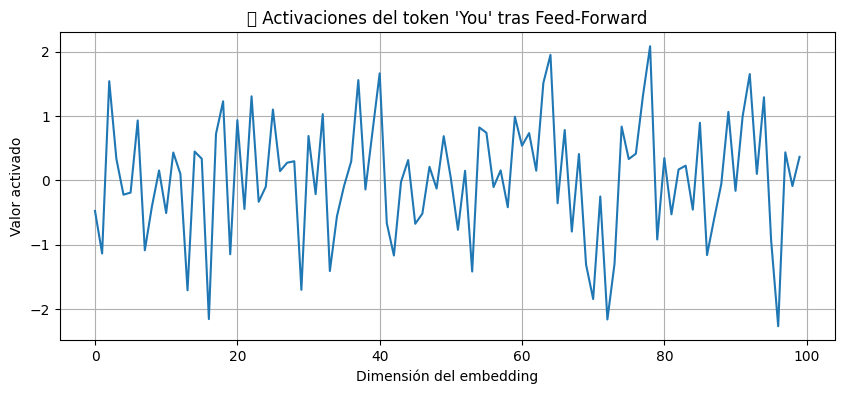

In [ ]:
# 6. Feed-Forward Network (FNN)
x = torch.tensor(emb_matrix[:30], dtype=torch.float32)
attn_output = final_output

d_model = 1536
d_ff = 512

# 6.1️. Layer Normalization (después del residual del bloque de atención)
layernorm1 = nn.LayerNorm(d_model)
x = layernorm1(x + attn_output)

# 6.2️. Feed-Forward Network (FFN)
ffn = nn.Sequential(
    nn.Linear(d_model, d_ff),
    nn.ReLU(),
    nn.Linear(d_ff, d_model)
)

# 6.3️. Aplicar FFN al resultado del bloque anterior
ffn_output = ffn(x)

# 6.4️. Residual connection + LayerNorm final
layernorm2 = nn.LayerNorm(d_model)
output = layernorm2(x + ffn_output)

# 6.5️. Resumen del proceso
print("\n FEED-FORWARD NETWORK")
print("Input shape:", x.shape)
print("FFN output shape:", output.shape)
print("Primeras 5 dimensiones del primer token:\n", output[0][:5])

# 6.6️. Seleccionar token a visualizar
token_index = 1
selected_token = tokens[token_index]

# 6.7️. Visualización de activaciones del token seleccionado
plt.figure(figsize=(10, 4))
plt.plot(output[token_index][:100].detach().numpy())
plt.title(f"🔹 Activaciones del token '{selected_token}' tras Feed-Forward")
plt.xlabel("Dimensión del embedding")
plt.ylabel("Valor activado")
plt.grid(True)
plt.show()